In [1]:
# importing libraries 
import numpy as np
import pandas as pd
import datetime as dt
from datetime import date,timedelta
import itertools

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

import seaborn as sns
sns.set(style = 'ticks')

# What promotional offer to give to a particular customer in a given time ?


# When to give a promotional offer to a particular customer and for what value?

In [2]:
#reading the data from the excel file
customer_ds = pd.read_excel('C:/Users/Jewin/Desktop/Jovita-DataSciene/DATA/Capstone/Online Retail.xlsx')

In [3]:
customer_ds

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [4]:
#Considering only customer's from UK , else payment value would differ
customer_ds=customer_ds[customer_ds['Country']=='United Kingdom']


In [5]:
#deleting the columns not required for analysis
customer_ds=customer_ds.drop(columns=['StockCode','Description','Country'])

In [6]:
#quering the null values
print(customer_ds.isnull().sum())

InvoiceNo           0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
dtype: int64


In [7]:
#deleting the rows with customer id as null
customer_ds=customer_ds[~customer_ds['CustomerID'].isnull()]

In [8]:
#Checking the data types
customer_ds.dtypes

InvoiceNo              object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
dtype: object

In [9]:
#Adding an columns to get the payment value (quantity*unit price)
customer_ds['payment_value']=customer_ds['Quantity']*customer_ds['UnitPrice']

In [10]:
customer_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,361878.0,11.077029,263.129266,-80995.0,2.00,4.00,12.00,80995.0
UnitPrice,361878.0,3.256007,70.654731,0.0,1.25,1.95,3.75,38970.0
CustomerID,361878.0,15547.871368,1594.402590,12346.0,14194.00,15514.00,16931.00,18287.0
payment_value,361878.0,18.702086,451.918484,-168469.6,3.75,10.20,17.70,168469.6


In [11]:
#function to calculate recency, frequeny and payment value for each customer
def calculate_RFP(customer_ds):
    #getting the maximum Invoice date in the dataset
    max_date=pd.to_datetime(customer_ds['InvoiceDate'].max(), format=None).to_period('D').to_timestamp()+ timedelta(days=1) 
    #getting the maximum invoice date for each customer (excluding the returned orders) and subtracting from max_date in dataset
    customer=customer_ds[customer_ds["Quantity"] > 0].groupby(["CustomerID"])["InvoiceDate"].max().reset_index()
    #getting the days of customer's recent visit
    customer['Recency']=(max_date-customer['InvoiceDate']).dt.days
    frequency=customer_ds[customer_ds["Quantity"] > 0].groupby(["CustomerID"]).InvoiceNo.nunique().reset_index()
    frequency.columns = ['CustomerID','Frequency']
    customer = pd.merge(customer, frequency, on='CustomerID')
    payment = customer_ds.groupby('CustomerID').payment_value.sum().reset_index()
    payment.columns = ['CustomerID','Payment']
    customer = pd.merge(customer, payment, on='CustomerID')
    return customer

In [12]:
#Function call to calculate recency , frequency and payment value for each customer
customer=calculate_RFP(customer_ds)

In [13]:
customer.head()

,CustomerID,InvoiceDate,Recency,Frequency,Payment
0,12346.0,2011-01-18 10:01:00,325,1,0.00
1,12747.0,2011-12-07 14:34:00,2,11,4196.01
2,12748.0,2011-12-09 12:20:00,0,210,29072.10
3,12749.0,2011-12-06 09:56:00,3,5,3868.20
4,12820.0,2011-12-06 15:12:00,3,4,942.34


In [14]:
customer.describe()

,CustomerID,Recency,Frequency,Payment
count,3921.000000,3921.000000,3921.000000,3921.000000
mean,15561.471563,91.722265,4.246111,1728.365007
std,1576.823683,99.528532,7.205750,6570.071115
min,12346.000000,0.000000,1.000000,-1165.300000
25%,14208.000000,17.000000,1.000000,289.820000
50%,15569.000000,50.000000,2.000000,633.660000
75%,16913.000000,142.000000,5.000000,1530.750000
max,18287.000000,373.000000,210.000000,256438.490000


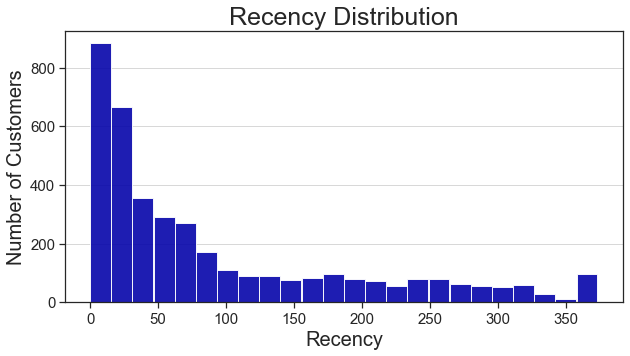

In [15]:
plt.figure(figsize=(10,5))
plt.hist(x=customer['Recency'], bins='auto', color='#0504aa',alpha=0.9, rwidth=0.99)
plt.title('Recency Distribution',fontsize=25)
plt.xlabel('Recency',fontsize=20)
plt.ylabel('Number of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', alpha=0.75)


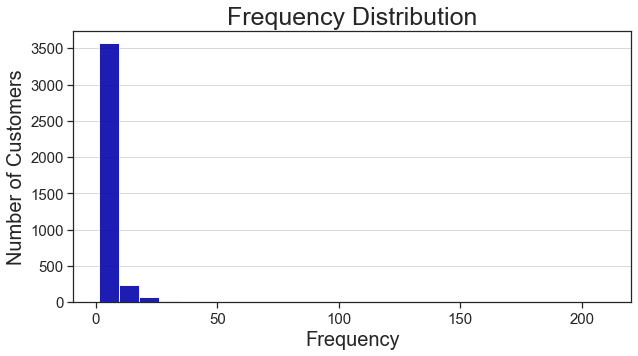

In [16]:
plt.figure(figsize=(10,5))
plt.hist(x=customer['Frequency'], bins=25, color='#0504aa',alpha=0.9, rwidth=0.99)
plt.title('Frequency Distribution',fontsize=25)
plt.xlabel('Frequency',fontsize=20)
plt.ylabel('Number of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', alpha=0.75)


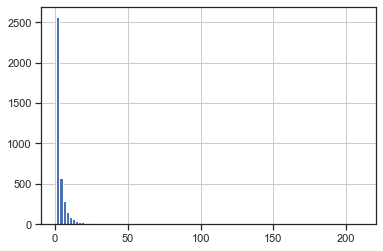

In [17]:
customer['Frequency'].hist(bins=100)

(array([12000., 13000., 14000., 15000., 16000., 17000., 18000., 19000.]),
 <a list of 8 Text yticklabel objects>)

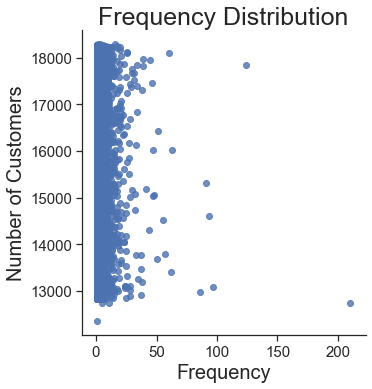

In [18]:
sns.lmplot(x='Frequency', y='CustomerID', data=customer, 
           fit_reg=False)
plt.title('Frequency Distribution',fontsize=25)
plt.xlabel('Frequency',fontsize=20)
plt.ylabel('Number of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

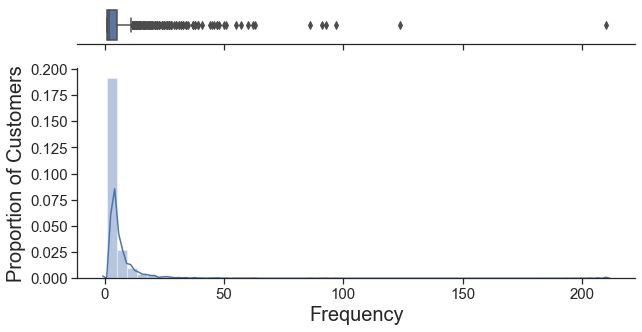

In [19]:
fig, ax = plt.subplots(2, 
                           figsize = (10, 5),
                           sharex = True, 
                           gridspec_kw = {'height_ratios': (0.15, 0.85)})

ax_box = ax[0]
ax_box = sns.boxplot(customer['Frequency'], ax = ax_box)
ax_box.set(title = '', yticks = [], xlabel = '')
sns.despine(ax = ax_box, left = True)

ax_hist = ax[1]
ax_hist = sns.distplot(customer['Frequency'], ax = ax_hist)
ax_hist.set(xlabel = 'Frequency')
sns.despine(ax = ax_hist)

plt.xlabel('Frequency',fontsize=20)
plt.ylabel('Proportion of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

(array([12000., 13000., 14000., 15000., 16000., 17000., 18000., 19000.]),
 <a list of 8 Text yticklabel objects>)

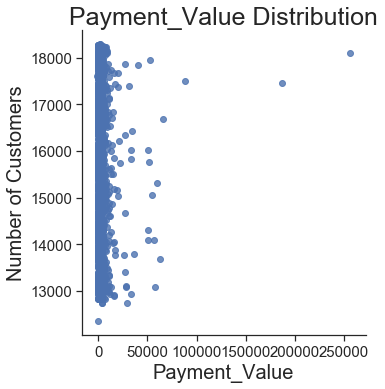

In [20]:
sns.lmplot(x='Payment', y='CustomerID', data=customer, 
           fit_reg=False)
plt.title('Payment_Value Distribution',fontsize=25)
plt.xlabel('Payment_Value',fontsize=20)
plt.ylabel('Number of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

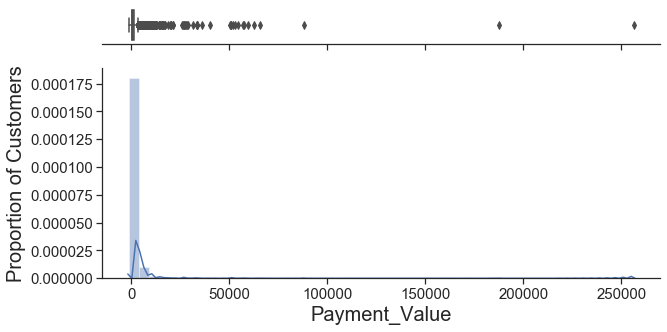

In [21]:
fig, ax = plt.subplots(2, 
                           figsize = (10, 5),
                           sharex = True, 
                           gridspec_kw = {'height_ratios': (0.15, 0.85)})

ax_box = ax[0]
ax_box = sns.boxplot(customer['Payment'], ax = ax_box)
ax_box.set(title = '', yticks = [], xlabel = '')
sns.despine(ax = ax_box, left = True)

ax_hist = ax[1]
ax_hist = sns.distplot(customer['Payment'], ax = ax_hist)
ax_hist.set(xlabel = 'Payment_Value')
sns.despine(ax = ax_hist)

plt.xlabel('Payment_Value',fontsize=20)
plt.ylabel('Proportion of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [22]:
plot_payment=customer[customer['Payment']<10000]

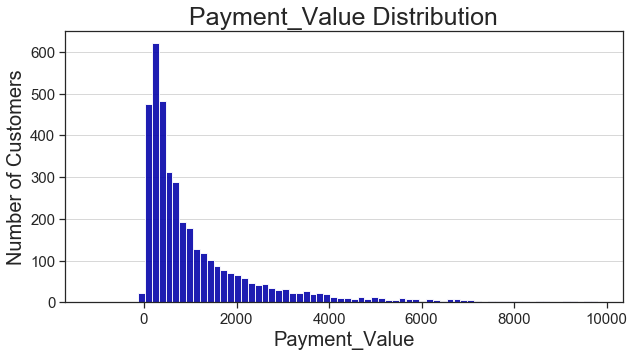

In [23]:
#Plotting the graph for payment value lesser than 10,000 for better visualization 

plt.figure(figsize=(10,5))
plt.hist(x=plot_payment['Payment'], bins='auto', color='#0504aa',alpha=0.9, rwidth=0.99)
plt.title('Payment_Value Distribution',fontsize=25)
plt.xlabel('Payment_Value',fontsize=20)
plt.ylabel('Number of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', alpha=0.75)

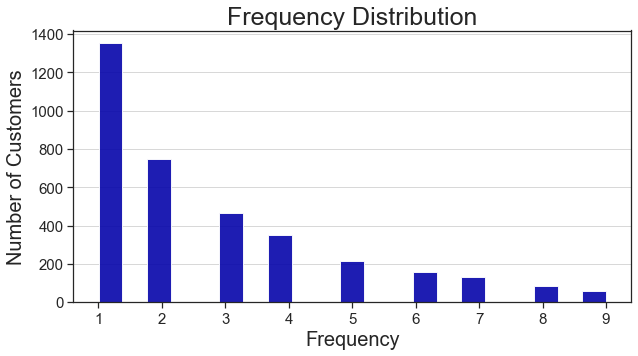

In [24]:
#Plotting the graph for payment value lesser than 10 for better visualization 

plot_frequency=customer[customer['Frequency']<10]
plt.figure(figsize=(10,5))
plt.hist(x=plot_frequency['Frequency'], bins='auto', color='#0504aa',alpha=0.9, rwidth=0.99)
plt.title('Frequency Distribution',fontsize=25)
plt.xlabel('Frequency',fontsize=20)
plt.ylabel('Number of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', alpha=0.75)

In [25]:
customer.corr()

,CustomerID,Recency,Frequency,Payment
CustomerID,1.000000,0.008299,-0.020160,0.007221
Recency,0.008299,1.000000,-0.273779,-0.146529
Frequency,-0.020160,-0.273779,1.000000,0.553537
Payment,0.007221,-0.146529,0.553537,1.000000


(6.0, 0)

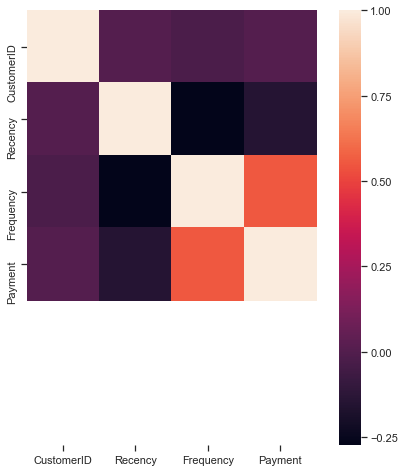

In [26]:
plt.figure(figsize=(8,8))
ax=sns.heatmap(customer.corr(),square = True)
ax.set_ylim(6.0, 0)

(array([-100000.,       0.,  100000.,  200000.,  300000.]),
 <a list of 0 Text xticklabel objects>)

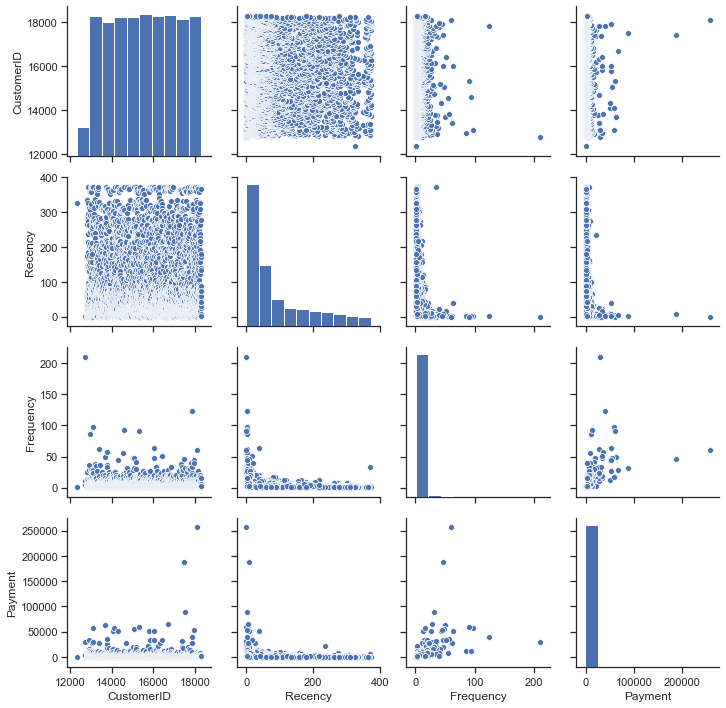

In [27]:
sns.pairplot(customer)
plt.xticks(fontsize=5)

In [28]:
#Coverting the recency from number of days to a ordered ranking number
customer['Recency_RANK']=customer['Recency'].rank(method='max')
customer['PCNT_RANK']=customer['Recency'].rank(method='max', pct=True)
customer['Ordered_Recency_Per']=1-customer['PCNT_RANK']

In [29]:
customer.head()

,CustomerID,InvoiceDate,Recency,Frequency,Payment,Recency_RANK,PCNT_RANK,Ordered_Recency_Per
0,12346.0,2011-01-18 10:01:00,325,1,0.00,3781.0,0.964295,0.035705
1,12747.0,2011-12-07 14:34:00,2,11,4196.01,208.0,0.053048,0.946952
2,12748.0,2011-12-09 12:20:00,0,210,29072.10,28.0,0.007141,0.992859
3,12749.0,2011-12-06 09:56:00,3,5,3868.20,292.0,0.074471,0.925529
4,12820.0,2011-12-06 15:12:00,3,4,942.34,292.0,0.074471,0.925529


In [30]:
#Coverting the frequency and payment value from number of days and currency value to a ordered ranking number
customer['Frequency_RANK']=customer['Frequency'].rank(method='max', pct=True)
customer['Payement_RANK']=customer['Payment'].rank(method='max', pct=True)

In [31]:
#Taking average of the 3 to rank the total for each customer
customer['Total_Rank']=(customer['Frequency_RANK']+customer['Payement_RANK']+customer['Ordered_Recency_Per'])/3

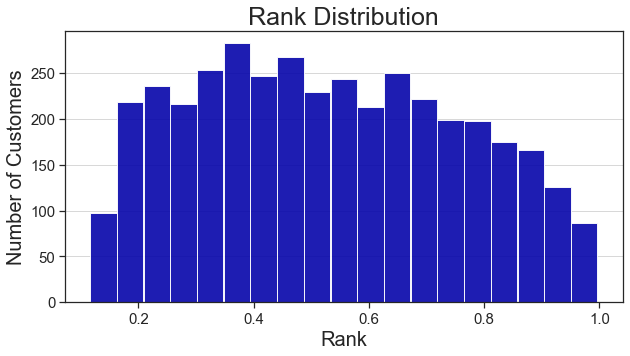

In [32]:
#customer['Total_Rank'].hist(bins=10, figsize=[14,6])
plt.figure(figsize=(10,5))
plt.hist(x=customer['Total_Rank'], bins='auto', color='#0504aa',alpha=0.9, rwidth=0.99)
plt.title('Rank Distribution',fontsize=25)
plt.xlabel('Rank',fontsize=20)
plt.ylabel('Number of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', alpha=0.75)

In [33]:
customer['CLTV']=pd.cut(customer.Total_Rank, bins=4, labels=np.arange(4), right=False)

In [34]:
customer.head()

,CustomerID,InvoiceDate,Recency,Frequency,Payment,Recency_RANK,PCNT_RANK,Ordered_Recency_Per,Frequency_RANK,Payement_RANK,Total_Rank,CLTV
0,12346.0,2011-01-18 10:01:00,325,1,0.00,3781.0,0.964295,0.035705,0.344555,0.004081,0.128114,0
1,12747.0,2011-12-07 14:34:00,2,11,4196.01,208.0,0.053048,0.946952,0.933435,0.930630,0.937006,3
2,12748.0,2011-12-09 12:20:00,0,210,29072.10,28.0,0.007141,0.992859,1.000000,0.994644,0.995834,3
3,12749.0,2011-12-06 09:56:00,3,5,3868.20,292.0,0.074471,0.925529,0.798266,0.922214,0.882003,3
4,12820.0,2011-12-06 15:12:00,3,4,942.34,292.0,0.074471,0.925529,0.742923,0.621270,0.763241,2


In [35]:
df=customer[['CustomerID','Ordered_Recency_Per','Frequency_RANK','Payement_RANK']]
Xs = normalize(df)

In [36]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Xs)
    Sum_of_squared_distances.append(km.inertia_)

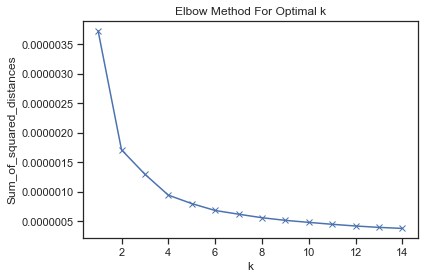

In [37]:
#Code to get the optimal value for k
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [38]:
k = 4
# 4 Clusters
k_mean2 = KMeans(n_clusters=k)
k_mean2.fit(Xs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [39]:
customer['Cluster'] = k_mean2.labels_

In [40]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    #print(df_final)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [41]:
customer=order_cluster('Cluster','Total_Rank',customer,True)

In [42]:
customer

,CustomerID,InvoiceDate,Recency,Frequency,Payment,Recency_RANK,PCNT_RANK,Ordered_Recency_Per,Frequency_RANK,Payement_RANK,Total_Rank,CLTV,Cluster
0,12346.0,2011-01-18 10:01:00,325,1,0.000000e+00,3781.0,0.964295,0.035705,0.344555,0.004081,0.128114,0,0
1,12821.0,2011-05-09 15:51:00,214,1,9.272000e+01,3322.0,0.847233,0.152767,0.344555,0.037235,0.178186,0,0
2,12829.0,2011-01-07 11:13:00,336,2,2.530500e+02,3810.0,0.971691,0.028309,0.534813,0.220097,0.261073,0,0
3,12831.0,2011-03-22 13:02:00,262,1,2.150500e+02,3539.0,0.902576,0.097424,0.344555,0.180311,0.207430,0,0
4,12833.0,2011-07-17 13:46:00,145,1,4.173800e+02,2957.0,0.754144,0.245856,0.344555,0.378475,0.322962,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3916,18270.0,2011-11-01 13:57:00,38,2,2.389500e+02,1724.0,0.439684,0.560316,0.534813,0.203775,0.432968,1,1
3917,18273.0,2011-12-07 13:16:00,2,3,2.040000e+02,208.0,0.053048,0.946952,0.653405,0.167304,0.589220,2,1
3918,18274.0,2011-11-09 17:03:00,30,1,1.243450e-14,1503.0,0.383321,0.616679,0.344555,0.004336,0.321857,0,1
3919,18276.0,2011-10-27 10:54:00,43,1,3.233600e+02,1826.0,0.465698,0.534302,0.344555,0.293037,0.390632,1,1


In [43]:
customer['Cluster'].value_counts()

0    1132
3    1032
2     959
1     798
Name: Cluster, dtype: int64

In [44]:
customer['CLTV'].value_counts()

1    1224
2    1040
0     956
3     701
Name: CLTV, dtype: int64

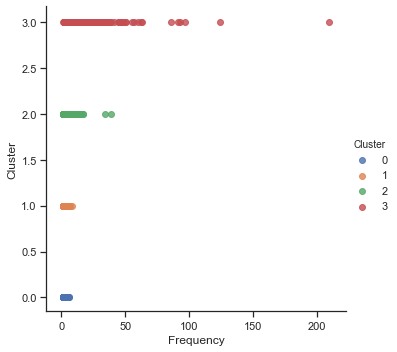

In [45]:
sns.lmplot(x='Frequency', y='Cluster', data=customer, hue='Cluster', 
           fit_reg=False)

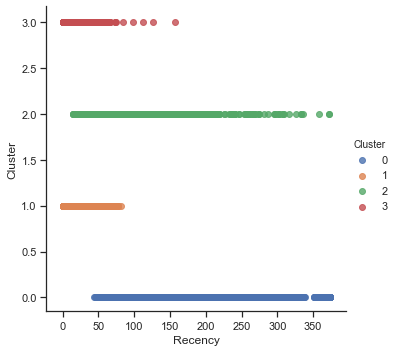

In [46]:
sns.lmplot(x='Recency', y='Cluster', data=customer, hue='Cluster', 
           fit_reg=False)

In [47]:
plot_frequency=customer[customer['Payment']<5000]

<Figure size 1440x720 with 0 Axes>

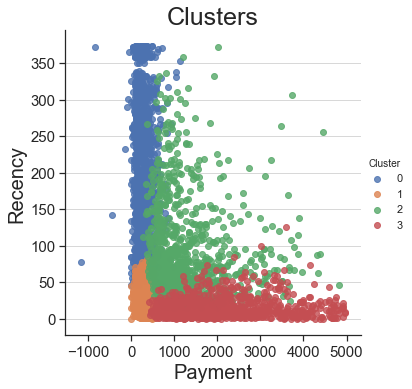

In [48]:
plt.figure(figsize=(20,10))
sns.lmplot(x='Payment', y='Recency', data=plot_frequency, hue='Cluster', fit_reg=False)
plt.title('Clusters',fontsize=25)
plt.xlabel('Payment',fontsize=20)
plt.ylabel('Recency',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', alpha=0.75)

In [49]:
filter1=customer['Recency']<200
filter2=customer['Frequency']<40
plot_frequency=customer[filter1 & filter2]
#plot_frequency=customer
#plot_frequency=customer[customer['Frequency']<30]

<Figure size 2160x1440 with 0 Axes>

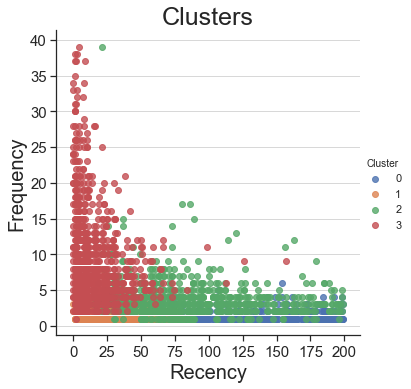

In [50]:
plt.figure(figsize=(30,20))
sns.lmplot(x='Recency', y='Frequency', data=plot_frequency, hue='Cluster', fit_reg=False)
plt.title('Clusters',fontsize=25)
plt.xlabel('Recency',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', alpha=0.75)
#plt.legend(loc='center right', labels=['Hell Yeh', 'Nah Bruh'])
plt.show()

In [51]:
cust_display=customer
cust_display=cust_display.drop(columns=['CustomerID','InvoiceDate','Recency_RANK','PCNT_RANK','Ordered_Recency_Per','Frequency_RANK','Payement_RANK','Total_Rank','CLTV'])

(array([-1.,  0.,  1.,  2.,  3.,  4.]), <a list of 0 Text xticklabel objects>)

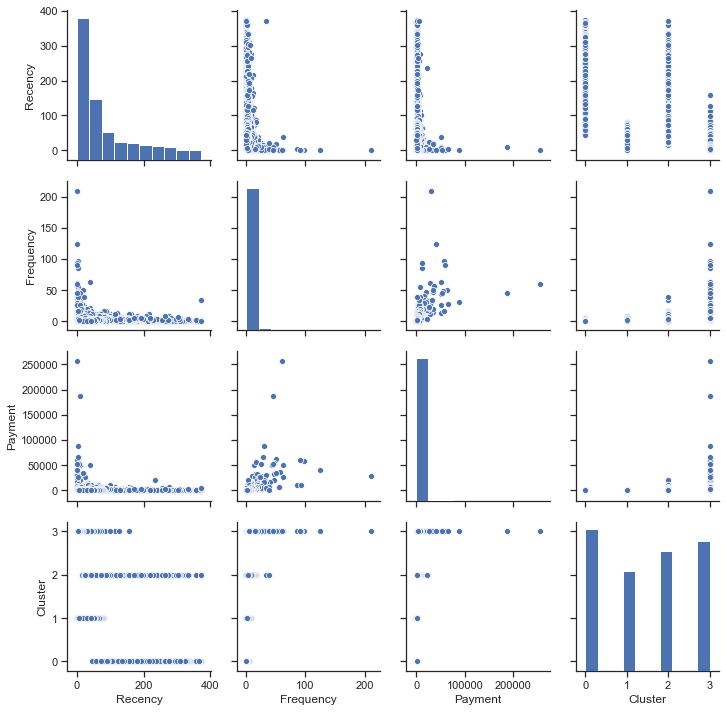

In [52]:
sns.pairplot(cust_display)
plt.xticks(fontsize=5)

In [53]:
Final_clusters=customer

# Predicting next purchase date

In [54]:
Final_end=pd.to_datetime(customer_ds['InvoiceDate'].max(), format=None).to_period('D').to_timestamp()
start_date=pd.to_datetime(customer_ds['InvoiceDate'].min(), format=None).to_period('D').to_timestamp()
split_date=date(2011,8,1)
end_date=date(2011,11,1)

In [55]:
customer_ds

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,payment_value
0,536365,6,2010-12-01 08:26:00,2.55,17850.0,15.30
1,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34
2,536365,8,2010-12-01 08:26:00,2.75,17850.0,22.00
3,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34
4,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34
...,...,...,...,...,...,...
541889,581585,12,2011-12-09 12:31:00,1.95,15804.0,23.40
541890,581586,8,2011-12-09 12:49:00,2.95,13113.0,23.60
541891,581586,24,2011-12-09 12:49:00,1.25,13113.0,30.00
541892,581586,24,2011-12-09 12:49:00,8.95,13113.0,214.80


In [56]:
training_period=customer_ds.loc[(customer_ds.InvoiceDate >= start_date) & (customer_ds.InvoiceDate <= split_date)]
testing_period=customer_ds.loc[(customer_ds.InvoiceDate > split_date) & (customer_ds.InvoiceDate <= end_date)]

In [57]:
data=pd.DataFrame(training_period['CustomerID'].unique())
data.columns = ['CustomerID']

In [58]:
#first purchase in testing period
testing_period_first_purchase = testing_period[testing_period["Quantity"] > 0].groupby('CustomerID').InvoiceDate.min().reset_index()
#testing_period_first_purchase = testing_period.groupby('CustomerID').InvoiceDate.min().reset_index()
testing_period_first_purchase.columns = ['CustomerID','MinPurchaseDate']

#Last purchase date in training period
training_period_last_purchase = training_period[training_period["Quantity"] > 0].groupby('CustomerID').InvoiceDate.max().reset_index()
#training_period_last_purchase = training_period.groupby('CustomerID').InvoiceDate.max().reset_index()
training_period_last_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [59]:
testing_period_first_purchase

,CustomerID,MinPurchaseDate
0,12747.0,2011-08-22 10:38:00
1,12748.0,2011-08-03 12:20:00
2,12749.0,2011-08-01 12:48:00
3,12820.0,2011-09-26 11:49:00
4,12822.0,2011-09-13 13:46:00
...,...,...
2227,18277.0,2011-10-12 15:22:00
2228,18278.0,2011-09-27 11:58:00
2229,18282.0,2011-08-05 13:35:00
2230,18283.0,2011-09-05 12:35:00


In [60]:
training_period_last_purchase

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:01:00
1,12747.0,2011-06-28 10:06:00
2,12748.0,2011-07-31 15:04:00
3,12749.0,2011-05-10 15:25:00
4,12820.0,2011-01-17 12:34:00
...,...,...
2843,18273.0,2011-03-27 11:22:00
2844,18280.0,2011-03-07 09:52:00
2845,18281.0,2011-06-12 10:53:00
2846,18283.0,2011-07-14 13:20:00


Below dataset gives the last date in training period and first date in testing period

In [61]:
train_test_merge=pd.merge(training_period_last_purchase,testing_period_first_purchase,on='CustomerID',how='left')

In [62]:
train_test_merge

,CustomerID,MaxPurchaseDate,MinPurchaseDate
0,12346.0,2011-01-18 10:01:00,NaT
1,12747.0,2011-06-28 10:06:00,2011-08-22 10:38:00
2,12748.0,2011-07-31 15:04:00,2011-08-03 12:20:00
3,12749.0,2011-05-10 15:25:00,2011-08-01 12:48:00
4,12820.0,2011-01-17 12:34:00,2011-09-26 11:49:00
...,...,...,...
2843,18273.0,2011-03-27 11:22:00,2011-09-05 11:27:00
2844,18280.0,2011-03-07 09:52:00,NaT
2845,18281.0,2011-06-12 10:53:00,NaT
2846,18283.0,2011-07-14 13:20:00,2011-09-05 12:35:00


In [63]:
train_test_merge['NextPurchaseDay_TestPeriod'] = (train_test_merge['MinPurchaseDate'] - train_test_merge['MaxPurchaseDate']).dt.days
data=pd.merge(data, train_test_merge[['CustomerID','NextPurchaseDay_TestPeriod']],on='CustomerID',how='left')

In [64]:
data
#NaN means they do not have a purchase date in that period . 
#for analysis we could consider it as a large next purchase date and fill that number by 999

,CustomerID,NextPurchaseDay_TestPeriod
0,17850.0,NaN
1,13047.0,46.0
2,13748.0,136.0
3,15100.0,NaN
4,15291.0,77.0
...,...,...
2882,13928.0,26.0
2883,14885.0,NaN
2884,13388.0,NaN
2885,15438.0,NaN


In [65]:
data = data.fillna(999)

In [66]:
df_Invoice_Day = training_period[['CustomerID','InvoiceDate']]
df_Invoice_Day['InvoiceDay'] = training_period['InvoiceDate'].dt.date

In [67]:
df_Invoice_Day

,CustomerID,InvoiceDate,InvoiceDay
0,17850.0,2010-12-01 08:26:00,2010-12-01
1,17850.0,2010-12-01 08:26:00,2010-12-01
2,17850.0,2010-12-01 08:26:00,2010-12-01
3,17850.0,2010-12-01 08:26:00,2010-12-01
4,17850.0,2010-12-01 08:26:00,2010-12-01
...,...,...,...
285416,17162.0,2011-07-31 16:04:00,2011-07-31
285417,17162.0,2011-07-31 16:04:00,2011-07-31
285418,17162.0,2011-07-31 16:04:00,2011-07-31
285419,17162.0,2011-07-31 16:04:00,2011-07-31


In [68]:
#drop duplicates
df_Invoice_Day = df_Invoice_Day.drop_duplicates(subset=['CustomerID','InvoiceDay'],keep='first')

In [69]:
#shifting last 3 purchase dates
df_Invoice_Day['n-1'] = df_Invoice_Day.groupby('CustomerID')['InvoiceDay'].shift(1)
df_Invoice_Day['n-2'] = df_Invoice_Day.groupby('CustomerID')['InvoiceDay'].shift(2)
df_Invoice_Day['n-3'] = df_Invoice_Day.groupby('CustomerID')['InvoiceDay'].shift(3)

In [70]:
df_Invoice_Day

,CustomerID,InvoiceDate,InvoiceDay,n-1,n-2,n-3
0,17850.0,2010-12-01 08:26:00,2010-12-01,NaN,NaN,NaN
9,13047.0,2010-12-01 08:34:00,2010-12-01,NaN,NaN,NaN
46,13748.0,2010-12-01 09:00:00,2010-12-01,NaN,NaN,NaN
65,15100.0,2010-12-01 09:09:00,2010-12-01,NaN,NaN,NaN
82,15291.0,2010-12-01 09:32:00,2010-12-01,NaN,NaN,NaN
...,...,...,...,...,...,...
285140,15819.0,2011-07-31 15:22:00,2011-07-31,2011-05-24,2011-03-08,NaN
285164,17841.0,2011-07-31 15:24:00,2011-07-31,2011-07-29,2011-07-27,2011-07-25
285268,17173.0,2011-07-31 15:26:00,2011-07-31,NaN,NaN,NaN
285280,16655.0,2011-07-31 15:31:00,2011-07-31,2011-06-07,2011-01-12,NaN


In [71]:
#getting the difference in days for last purchases in training period
df_Invoice_Day['DayDiff1'] = (df_Invoice_Day['InvoiceDay'] - df_Invoice_Day['n-1']).dt.days
df_Invoice_Day['DayDiff2'] = (df_Invoice_Day['n-1'] - df_Invoice_Day['n-2']).dt.days
df_Invoice_Day['DayDiff3'] = (df_Invoice_Day['n-2'] - df_Invoice_Day['n-3']).dt.days

In [72]:
df_Invoice_Day

,CustomerID,InvoiceDate,InvoiceDay,n-1,n-2,n-3,DayDiff1,DayDiff2,DayDiff3
0,17850.0,2010-12-01 08:26:00,2010-12-01,NaN,NaN,NaN,NaN,NaN,NaN
9,13047.0,2010-12-01 08:34:00,2010-12-01,NaN,NaN,NaN,NaN,NaN,NaN
46,13748.0,2010-12-01 09:00:00,2010-12-01,NaN,NaN,NaN,NaN,NaN,NaN
65,15100.0,2010-12-01 09:09:00,2010-12-01,NaN,NaN,NaN,NaN,NaN,NaN
82,15291.0,2010-12-01 09:32:00,2010-12-01,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
285140,15819.0,2011-07-31 15:22:00,2011-07-31,2011-05-24,2011-03-08,NaN,68.0,77.0,NaN
285164,17841.0,2011-07-31 15:24:00,2011-07-31,2011-07-29,2011-07-27,2011-07-25,2.0,2.0,2.0
285268,17173.0,2011-07-31 15:26:00,2011-07-31,NaN,NaN,NaN,NaN,NaN,NaN
285280,16655.0,2011-07-31 15:31:00,2011-07-31,2011-06-07,2011-01-12,NaN,54.0,146.0,NaN


In [73]:
#retaining only the customers who have 3 or more occurances in training period
day_order_last = df_Invoice_Day.drop_duplicates(subset=['CustomerID'],keep='last')

In [74]:
day_order_last = day_order_last.dropna()

In [75]:
day_order_last

,CustomerID,InvoiceDate,InvoiceDay,n-1,n-2,n-3,DayDiff1,DayDiff2,DayDiff3
56833,15100.0,2011-01-13 17:09:00,2011-01-13,2011-01-10,2010-12-16,2010-12-08,3.0,25.0,8.0
57220,16233.0,2011-01-14 10:31:00,2011-01-14,2010-12-16,2010-12-14,2010-12-08,29.0,2.0,6.0
73784,14299.0,2011-01-27 14:26:00,2011-01-27,2011-01-25,2011-01-14,2011-01-13,2.0,11.0,1.0
75476,17062.0,2011-01-30 11:01:00,2011-01-30,2010-12-16,2010-12-09,2010-12-05,45.0,7.0,4.0
78905,15107.0,2011-02-01 14:46:00,2011-02-01,2011-01-13,2011-01-11,2011-01-09,19.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...
284783,14414.0,2011-07-31 13:33:00,2011-07-31,2011-07-29,2011-07-26,2010-12-16,2.0,3.0,222.0
284804,14092.0,2011-07-31 13:36:00,2011-07-31,2011-06-22,2011-05-27,2011-04-17,39.0,26.0,40.0
285139,12748.0,2011-07-31 15:04:00,2011-07-31,2011-07-29,2011-07-28,2011-07-21,2.0,1.0,7.0
285164,17841.0,2011-07-31 15:24:00,2011-07-31,2011-07-29,2011-07-27,2011-07-25,2.0,2.0,2.0


In [76]:
data = pd.merge(data, day_order_last[['CustomerID','InvoiceDay','DayDiff1','DayDiff2','DayDiff3']], on='CustomerID')

In [77]:
data

,CustomerID,NextPurchaseDay_TestPeriod,InvoiceDay,DayDiff1,DayDiff2,DayDiff3
0,13047.0,46.0,2011-07-08,19.0,4.0,42.0
1,15100.0,999.0,2011-01-13,3.0,25.0,8.0
2,15291.0,77.0,2011-06-20,8.0,67.0,5.0
3,14688.0,12.0,2011-07-21,9.0,14.0,15.0
4,17809.0,43.0,2011-07-18,24.0,4.0,45.0
...,...,...,...,...,...,...
772,17651.0,76.0,2011-07-19,12.0,14.0,3.0
773,14808.0,69.0,2011-07-18,8.0,14.0,6.0
774,12830.0,42.0,2011-07-28,7.0,15.0,15.0
775,13420.0,999.0,2011-07-28,15.0,7.0,14.0


(array([ 9., 19., 19., 34., 29., 34., 32., 26., 32., 20., 29., 28., 24.,
        28., 18., 10., 20., 19., 13., 20., 24.,  9., 16., 19., 11.,  4.,
        12., 12., 11.,  7.,  7.,  9.,  5.,  2.,  3.,  5.,  4.,  1.,  1.,
         0.,  4.,  3.,  1.,  0.,  2.,  3.,  0.,  1.,  0.,  1.]),
 array([  1.  ,   4.96,   8.92,  12.88,  16.84,  20.8 ,  24.76,  28.72,
         32.68,  36.64,  40.6 ,  44.56,  48.52,  52.48,  56.44,  60.4 ,
         64.36,  68.32,  72.28,  76.24,  80.2 ,  84.16,  88.12,  92.08,
         96.04, 100.  , 103.96, 107.92, 111.88, 115.84, 119.8 , 123.76,
        127.72, 131.68, 135.64, 139.6 , 143.56, 147.52, 151.48, 155.44,
        159.4 , 163.36, 167.32, 171.28, 175.24, 179.2 , 183.16, 187.12,
        191.08, 195.04, 199.  ]),
 <a list of 50 Patch objects>)

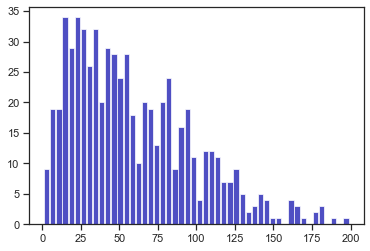

In [78]:
plot_data=data[data['NextPurchaseDay_TestPeriod']<200]
plt.hist(x=plot_data['NextPurchaseDay_TestPeriod'], bins=50, color='#0504aa',
                            alpha=0.7, rwidth=0.85)

In [79]:
test = pd.merge(customer, data[['CustomerID','InvoiceDay','DayDiff1','DayDiff2','DayDiff3','NextPurchaseDay_TestPeriod']], on='CustomerID')

In [80]:
data=test

In [81]:
#Rank the next purchase day
data['NextPurchaseDayRange'] = 0
data.loc[data.NextPurchaseDay_TestPeriod>30,'NextPurchaseDayRange'] = 1
data.loc[data.NextPurchaseDay_TestPeriod>70,'NextPurchaseDayRange'] = 2
data.loc[data.NextPurchaseDay_TestPeriod>150,'NextPurchaseDayRange'] = 3


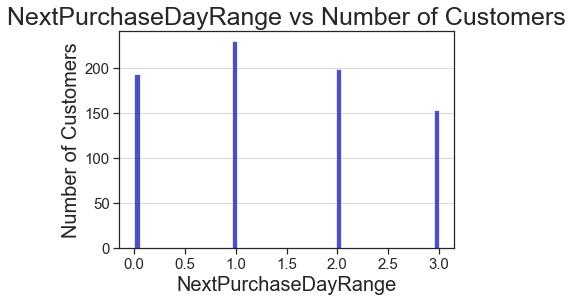

In [82]:
plt.hist(x=data['NextPurchaseDayRange'], bins=50, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.title('NextPurchaseDayRange vs Number of Customers',fontsize=25)
plt.xlabel('NextPurchaseDayRange',fontsize=20)
plt.ylabel('Number of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', alpha=0.75)

In [83]:
data

,CustomerID,InvoiceDate,Recency,Frequency,Payment,Recency_RANK,PCNT_RANK,Ordered_Recency_Per,Frequency_RANK,Payement_RANK,Total_Rank,CLTV,Cluster,InvoiceDay,DayDiff1,DayDiff2,DayDiff3,NextPurchaseDay_TestPeriod,NextPurchaseDayRange
0,12888.0,2011-05-09 16:02:00,214,2,313.77,3322.0,0.847233,0.152767,0.534813,0.282071,0.323217,0,0,2011-05-09,6.0,32.0,3.0,999.0,3
1,13420.0,2011-07-13 08:48:00,149,2,140.35,2976.0,0.758990,0.241010,0.534813,0.092833,0.289552,0,0,2011-07-28,15.0,7.0,14.0,999.0,3
2,15107.0,2011-02-01 14:46:00,311,6,247.66,3735.0,0.952563,0.047437,0.838562,0.212956,0.366318,1,0,2011-02-01,19.0,2.0,2.0,999.0,3
3,15646.0,2011-07-05 09:53:00,157,3,425.14,3024.0,0.771232,0.228768,0.653405,0.383831,0.422001,1,0,2011-07-05,85.0,4.0,126.0,999.0,3
4,15648.0,2011-05-19 15:53:00,204,2,599.90,3275.0,0.835246,0.164754,0.534813,0.478449,0.392672,1,0,2011-05-19,44.0,6.0,13.0,999.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,16566.0,2011-11-24 16:34:00,15,5,614.01,882.0,0.224943,0.775057,0.798266,0.488906,0.687410,2,1,2011-06-22,20.0,2.0,100.0,113.0,2
773,16668.0,2011-11-24 17:43:00,15,6,306.72,882.0,0.224943,0.775057,0.838562,0.270849,0.628156,2,1,2011-07-24,44.0,32.0,70.0,21.0,0
774,17115.0,2011-12-01 14:30:00,8,3,806.90,560.0,0.142821,0.857179,0.653405,0.578934,0.696506,2,1,2011-06-13,3.0,44.0,7.0,999.0,3
775,17526.0,2011-12-05 11:05:00,4,4,706.70,378.0,0.096404,0.903596,0.742923,0.540933,0.729151,2,1,2011-05-19,49.0,37.0,70.0,999.0,3


In [84]:
data['NextPurchaseDayRange'].value_counts()

1    230
2    199
0    194
3    154
Name: NextPurchaseDayRange, dtype: int64

In [85]:
data.corr()

,CustomerID,Recency,Frequency,Payment,Recency_RANK,PCNT_RANK,Ordered_Recency_Per,Frequency_RANK,Payement_RANK,Total_Rank,Cluster,DayDiff1,DayDiff2,DayDiff3,NextPurchaseDay_TestPeriod,NextPurchaseDayRange
CustomerID,1.000000,0.035887,-0.046152,0.034937,0.028687,0.028687,-0.028687,0.002794,-0.063633,-0.038576,-0.233532,0.000306,0.029387,0.034607,0.040046,0.039211
Recency,0.035887,1.000000,-0.298159,-0.166646,0.896083,0.896083,-0.896083,-0.629670,-0.576755,-0.852759,-0.730332,0.067944,0.017551,-0.007812,0.611089,0.476215
Frequency,-0.046152,-0.298159,1.000000,0.493679,-0.397187,-0.397187,0.397187,0.511768,0.403556,0.481013,0.272454,-0.235768,-0.244658,-0.214897,-0.266419,-0.445981
Payment,0.034937,-0.166646,0.493679,1.000000,-0.228129,-0.228129,0.228129,0.280625,0.292504,0.295198,0.164429,-0.146260,-0.143457,-0.116155,-0.145350,-0.256471
Recency_RANK,0.028687,0.896083,-0.397187,-0.228129,1.000000,1.000000,-1.000000,-0.649827,-0.565138,-0.912136,-0.714514,0.127187,0.085650,0.062425,0.462288,0.441369
PCNT_RANK,0.028687,0.896083,-0.397187,-0.228129,1.000000,1.000000,-1.000000,-0.649827,-0.565138,-0.912136,-0.714514,0.127187,0.085650,0.062425,0.462288,0.441369
Ordered_Recency_Per,-0.028687,-0.896083,0.397187,0.228129,-1.000000,-1.000000,1.000000,0.649827,0.565138,0.912136,0.714514,-0.127187,-0.085650,-0.062425,-0.462288,-0.441369
Frequency_RANK,0.002794,-0.629670,0.511768,0.280625,-0.649827,-0.649827,0.649827,1.000000,0.716180,0.841980,0.637190,-0.159863,-0.211462,-0.170866,-0.576182,-0.644210
Payement_RANK,-0.063633,-0.576755,0.403556,0.292504,-0.565138,-0.565138,0.565138,0.716180,1.000000,0.834592,0.716718,-0.188176,-0.139597,-0.103990,-0.523191,-0.535334
Total_Rank,-0.038576,-0.852759,0.481013,0.295198,-0.912136,-0.912136,0.912136,0.841980,0.834592,1.000000,0.801121,-0.174316,-0.144299,-0.109573,-0.574862,-0.581907


In [86]:
#sns.pairplot(data)

In [87]:
#plt.figure(figsize=(8,8))
#sns.heatmap(data.corr())

In [88]:
#feature engineering for better results
data['Average']=(data.DayDiff1+data.DayDiff2+data.DayDiff3)/3

In [89]:
#getting logrithmic value
data['Log']=np.log(data['Average'])

In [91]:
data.to_csv(r'C:/Users/Jewin/Desktop/Jovita-DataSciene/DATA/Capstone/Online Retail_Test.csv', index = False)

# Above code is put in a function to reuse it for evaluation period

In [95]:
def data_prep(data,start_date,end_date,split_date):
    training_period=customer_ds.loc[(customer_ds.InvoiceDate >= start_date) & (customer_ds.InvoiceDate <= split_date)]
    testing_period=customer_ds.loc[(customer_ds.InvoiceDate > split_date) & (customer_ds.InvoiceDate <= end_date)]
    data=pd.DataFrame(training_period['CustomerID'].unique())
    data.columns = ['CustomerID']
    #first purchase in testing period
    testing_period_first_purchase = testing_period[testing_period["Quantity"] > 0].groupby('CustomerID').InvoiceDate.min().reset_index()
    #testing_period_first_purchase = testing_period.groupby('CustomerID').InvoiceDate.min().reset_index()
    testing_period_first_purchase.columns = ['CustomerID','MinPurchaseDate']

    #Last purchase date in training period
    training_period_last_purchase = training_period[training_period["Quantity"] > 0].groupby('CustomerID').InvoiceDate.max().reset_index()
    #training_period_last_purchase = training_period.groupby('CustomerID').InvoiceDate.max().reset_index()
    training_period_last_purchase.columns = ['CustomerID','MaxPurchaseDate']
    
    train_test_merge=pd.merge(training_period_last_purchase,testing_period_first_purchase,on='CustomerID',how='left')
    train_test_merge['NextPurchaseDay_TestPeriod'] = (train_test_merge['MinPurchaseDate'] - train_test_merge['MaxPurchaseDate']).dt.days
    data=pd.merge(data, train_test_merge[['CustomerID','NextPurchaseDay_TestPeriod']],on='CustomerID',how='left')
    data = data.fillna(999)
    df_Invoice_Day = training_period[['CustomerID','InvoiceDate']]
    df_Invoice_Day['InvoiceDay'] = training_period['InvoiceDate'].dt.date
    df_Invoice_Day = df_Invoice_Day.drop_duplicates(subset=['CustomerID','InvoiceDay'],keep='first')
    df_Invoice_Day['n-1'] = df_Invoice_Day.groupby('CustomerID')['InvoiceDay'].shift(1)
    df_Invoice_Day['n-2'] = df_Invoice_Day.groupby('CustomerID')['InvoiceDay'].shift(2)
    df_Invoice_Day['n-3'] = df_Invoice_Day.groupby('CustomerID')['InvoiceDay'].shift(3)
    df_Invoice_Day['DayDiff1'] = (df_Invoice_Day['InvoiceDay'] - df_Invoice_Day['n-1']).dt.days
    df_Invoice_Day['DayDiff2'] = (df_Invoice_Day['n-1'] - df_Invoice_Day['n-2']).dt.days
    df_Invoice_Day['DayDiff3'] = (df_Invoice_Day['n-2'] - df_Invoice_Day['n-3']).dt.days
    day_order_last = df_Invoice_Day.drop_duplicates(subset=['CustomerID'],keep='last')
    day_order_last = day_order_last.dropna()
    data = pd.merge(data, day_order_last[['CustomerID','InvoiceDay','DayDiff1','DayDiff2','DayDiff3']], on='CustomerID')
    test = pd.merge(customer, data[['CustomerID','InvoiceDay','DayDiff1','DayDiff2','DayDiff3','NextPurchaseDay_TestPeriod']], on='CustomerID')
    data=test
    data['NextPurchaseDayRange'] = 0
    data.loc[data.NextPurchaseDay_TestPeriod>30,'NextPurchaseDayRange'] = 1
    data.loc[data.NextPurchaseDay_TestPeriod>70,'NextPurchaseDayRange'] = 2
    data.loc[data.NextPurchaseDay_TestPeriod>150,'NextPurchaseDayRange'] = 3
    
    data['Average']=(data.DayDiff1+data.DayDiff2+data.DayDiff3)/3
    data['Log']=np.log(data['Average'])
    
    return data


In [96]:
check_data1=data_prep(customer_ds,start_date,Final_end,end_date)

In [97]:
check_data1

,CustomerID,InvoiceDate,Recency,Frequency,Payment,Recency_RANK,PCNT_RANK,Ordered_Recency_Per,Frequency_RANK,Payement_RANK,...,CLTV,Cluster,InvoiceDay,DayDiff1,DayDiff2,DayDiff3,NextPurchaseDay_TestPeriod,NextPurchaseDayRange,Average,Log
0,12888.0,2011-05-09 16:02:00,214,2,313.77,3322.0,0.847233,0.152767,0.534813,0.282071,...,0,0,2011-05-09,6.0,32.0,3.0,999.0,3,13.666667,2.614960
1,13217.0,2011-08-09 15:32:00,122,3,133.62,2830.0,0.721755,0.278245,0.653405,0.083142,...,1,0,2011-08-09,9.0,11.0,14.0,999.0,3,11.333333,2.427748
2,13420.0,2011-07-13 08:48:00,149,2,140.35,2976.0,0.758990,0.241010,0.534813,0.092833,...,0,0,2011-07-28,15.0,7.0,14.0,999.0,3,12.000000,2.484907
3,15107.0,2011-02-01 14:46:00,311,6,247.66,3735.0,0.952563,0.047437,0.838562,0.212956,...,1,0,2011-02-01,19.0,2.0,2.0,999.0,3,7.666667,2.036882
4,15646.0,2011-07-05 09:53:00,157,3,425.14,3024.0,0.771232,0.228768,0.653405,0.383831,...,1,0,2011-07-05,85.0,4.0,126.0,999.0,3,71.666667,4.272026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1189,17526.0,2011-12-05 11:05:00,4,4,706.70,378.0,0.096404,0.903596,0.742923,0.540933,...,2,1,2011-05-19,49.0,37.0,70.0,286.0,3,52.000000,3.951244
1190,17888.0,2011-11-18 13:45:00,21,8,525.78,1151.0,0.293548,0.706452,0.893905,0.440959,...,2,1,2011-10-11,20.0,82.0,51.0,21.0,0,51.000000,3.931826
1191,17929.0,2011-11-28 16:01:00,11,4,834.50,749.0,0.191023,0.808977,0.742923,0.587605,...,2,1,2011-09-23,35.0,142.0,54.0,101.0,2,77.000000,4.343805
1192,18211.0,2011-11-14 08:10:00,25,5,600.07,1345.0,0.343025,0.656975,0.798266,0.479470,...,2,1,2011-10-27,42.0,51.0,142.0,17.0,0,78.333333,4.360973


In [98]:
check_data1.to_csv(r'C:/Users/Jewin/Desktop/Jovita-DataSciene/DATA/Capstone/Online Retail_Evaluation.csv', index = False)